In [ ]:
!pip install --upgrade sympy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 72.7 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cud

Using device: cpu
Member set size: 22611, Non-member set size: 22611
Training target model...
Epoch 10/50, Loss: 0.2908
Epoch 20/50, Loss: 0.2562
Epoch 30/50, Loss: 0.2247
Epoch 40/50, Loss: 0.1992
Epoch 50/50, Loss: 0.1802
Target model training complete.
Member loss statistics - Min: -0.0000, Max: 5.4959, Mean: 0.1664
Non-member loss statistics - Min: -0.0000, Max: 147.0470, Mean: 0.5831


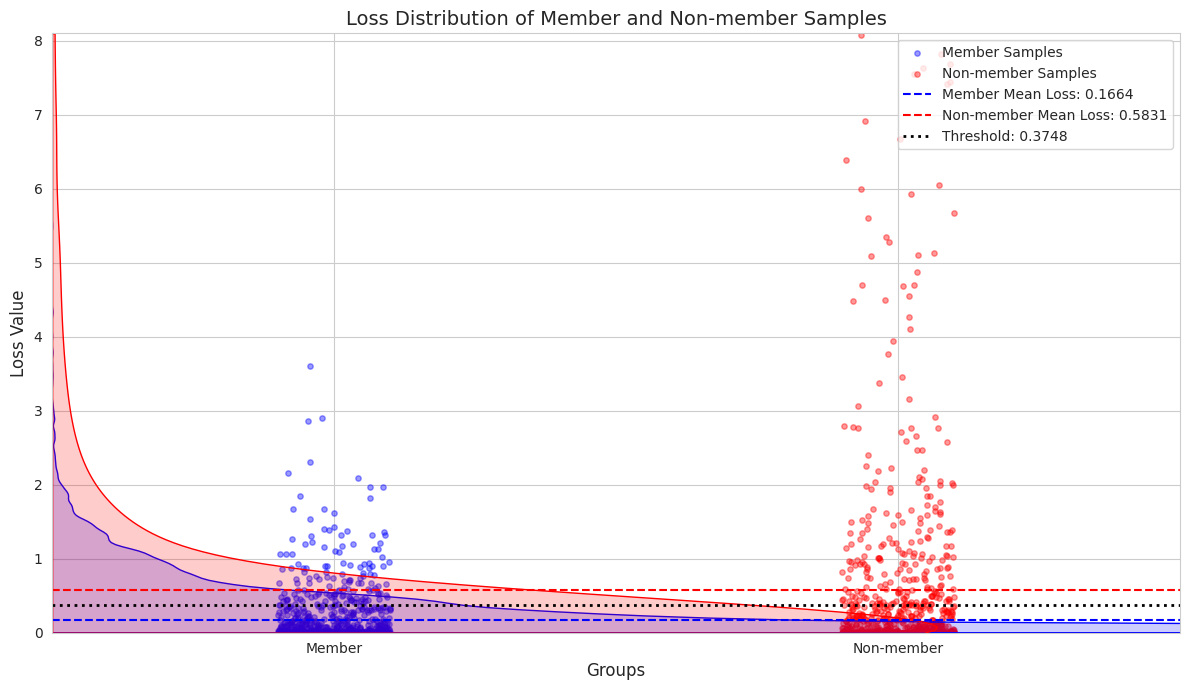

Avg member loss: 0.1664 | Avg non-member loss: 0.5831 | Threshold: 0.3748
Validation set size: 9046, Members: 4523.0, Non-members: 4523.0
Validation member loss mean: 0.1628, Non-member loss mean: 0.5578
Threshold Attack -> Accuracy: 0.5430 | AUC: 0.5320
Validation member confidence mean: 0.8864
Validation non-member confidence mean: 0.8124
Confidence threshold: 0.8494
Confidence Attack -> Accuracy: 0.5405 | AUC: 0.5320


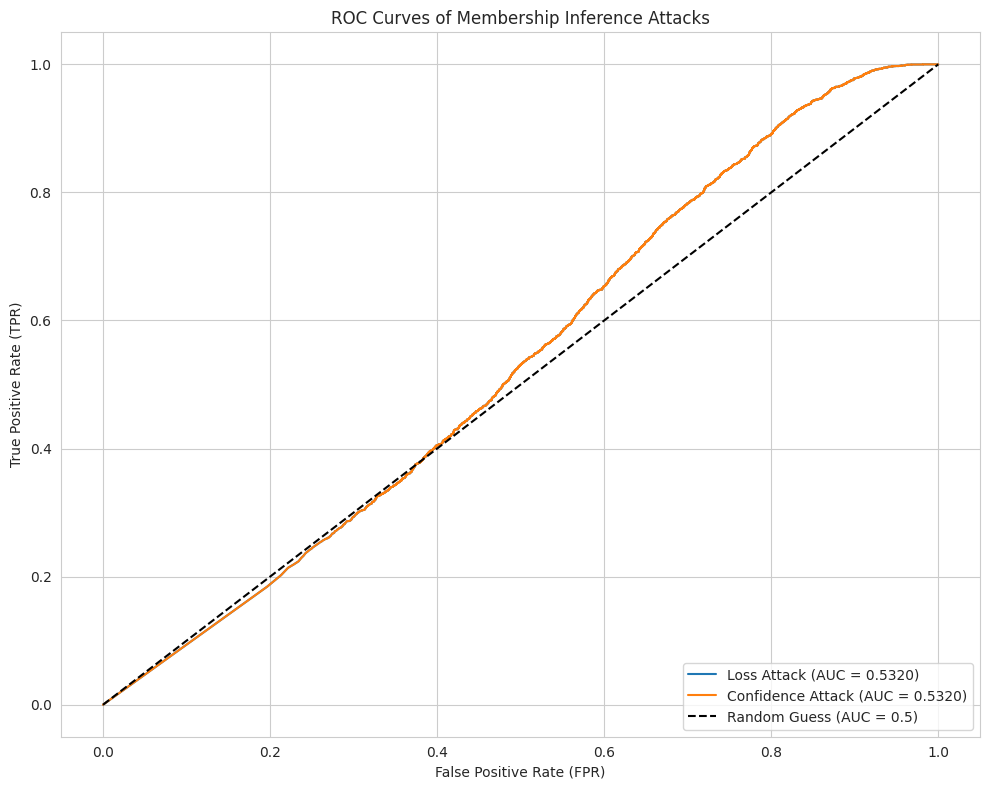

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# -----------------------------------------------
# 1. Load ADULT dataset and preprocess
# -----------------------------------------------
adult = fetch_openml(name='adult', version=2, as_frame=True)
X = adult.data
y = (adult.target == '>50K').astype(int)

# Simple preprocessing (handle missing values + one-hot encoding)
X = X.dropna()
X = pd.get_dummies(X)
y = y[X.index]  # Align indices

# Standardize
tscaler = StandardScaler()
X_scaled = tscaler.fit_transform(X)

# Split dataset into member and non-member sets (50%/50%)
idx = np.arange(X_scaled.shape[0])
member_idx, nonmember_idx = train_test_split(idx, test_size=0.5, random_state=42)
X_member = X_scaled[member_idx]
y_member = y.values[member_idx]
X_nonmember = X_scaled[nonmember_idx]
y_nonmember = y.values[nonmember_idx]

print(f"Member set size: {len(X_member)}, Non-member set size: {len(X_nonmember)}")

# -----------------------------------------------
# 2. Define and train target model (MLP)
# -----------------------------------------------
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.net(x)


def train_target_model(X_np, y_np, epochs=50, lr=1e-3, batch_size=128):
    model = MLP(input_dim=X_np.shape[1]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    dataset = TensorDataset(
        torch.tensor(X_np, dtype=torch.float32),
        torch.tensor(y_np, dtype=torch.long)
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(dataloader):.4f}")

    return model

print("Training target model...")
target_model = train_target_model(X_member, y_member)
print("Target model training complete.")

# -----------------------------------------------
# 3. Calculate per-sample Loss for members and non-members and visualize
# -----------------------------------------------
criterion_none = nn.CrossEntropyLoss(reduction='none')

def compute_losses(model, X_np, y_np):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X_np, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y_np, dtype=torch.long).to(device)
        logits = model(X_tensor)
        losses = criterion_none(logits, y_tensor)
        return losses.cpu().numpy()

# Calculate training set (member) losses
loss_member = compute_losses(target_model, X_member, y_member)
print(f"Member loss statistics - Min: {loss_member.min():.4f}, Max: {loss_member.max():.4f}, Mean: {loss_member.mean():.4f}")

# Calculate test set (non-member) losses
loss_nonmember = compute_losses(target_model, X_nonmember, y_nonmember)
print(f"Non-member loss statistics - Min: {loss_nonmember.min():.4f}, Max: {loss_nonmember.max():.4f}, Mean: {loss_nonmember.mean():.4f}")

# -----------------------------------------------
# Create scatter plot visualization
# -----------------------------------------------
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Determine reasonable x-axis range
x_min = min(loss_member.min(), loss_nonmember.min())
x_max = np.percentile(np.concatenate([loss_member, loss_nonmember]), 99.5)  # Use 99.5 percentile to avoid extremes

# Sample some points to avoid overcrowding
max_points = 1000  # Maximum number of points to show

if len(loss_member) > max_points:
    member_indices = random.sample(range(len(loss_member)), max_points)
    member_x = np.ones(max_points) * 0.25  # X-position for member points
    member_y = loss_member[member_indices]
else:
    member_x = np.ones(len(loss_member)) * 0.25
    member_y = loss_member

if len(loss_nonmember) > max_points:
    nonmember_indices = random.sample(range(len(loss_nonmember)), max_points)
    nonmember_x = np.ones(max_points) * 0.75  # X-position for non-member points
    nonmember_y = loss_nonmember[nonmember_indices]
else:
    nonmember_x = np.ones(len(loss_nonmember)) * 0.75
    nonmember_y = loss_nonmember

# Add some jitter to x positions
jitter = 0.05
member_x = member_x + np.random.uniform(-jitter, jitter, size=len(member_x))
nonmember_x = nonmember_x + np.random.uniform(-jitter, jitter, size=len(nonmember_x))

# Create scatter plot
plt.scatter(member_x, member_y, alpha=0.4, color="blue", label="Member Samples", s=15)
plt.scatter(nonmember_x, nonmember_y, alpha=0.4, color="red", label="Non-member Samples", s=15)

# Add KDE plots on the side for density visualization
kde_x_member = np.linspace(x_min, x_max, 1000)
kde_y_member = sns.kdeplot(y=loss_member, color="blue", fill=True, alpha=0.2, clip=(x_min, x_max))
kde_y_nonmember = sns.kdeplot(y=loss_nonmember, color="red", fill=True, alpha=0.2, clip=(x_min, x_max))

# Add mean and threshold lines
plt.axhline(loss_member.mean(), color='blue', linestyle='dashed', linewidth=1.5,
           label=f'Member Mean Loss: {loss_member.mean():.4f}')
plt.axhline(loss_nonmember.mean(), color='red', linestyle='dashed', linewidth=1.5,
           label=f'Non-member Mean Loss: {loss_nonmember.mean():.4f}')
plt.axhline((loss_member.mean() + loss_nonmember.mean()) / 2, color='black', linestyle='dotted',
           linewidth=2, label=f'Threshold: {(loss_member.mean() + loss_nonmember.mean()) / 2:.4f}')

plt.legend(loc='upper right')
plt.xlabel('Groups', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.title('Loss Distribution of Member and Non-member Samples', fontsize=14)
plt.xticks([0.25, 0.75], ['Member', 'Non-member'])
plt.xlim(0, 1)
plt.ylim(x_min, x_max)
plt.tight_layout()
plt.savefig('loss_scatter_distribution.png', dpi=300)
plt.show()

# -----------------------------------------------
# 4. Calculate average Loss, threshold, and evaluate
# -----------------------------------------------
avg_mem = loss_member.mean()
avg_nonmem = loss_nonmember.mean()
threshold = (avg_mem + avg_nonmem) / 2
print(f"Avg member loss: {avg_mem:.4f} | Avg non-member loss: {avg_nonmem:.4f} | Threshold: {threshold:.4f}")

# -----------------------------------------------
# 5. Construct validation set for evaluation
# -----------------------------------------------

# Split 20% from both member and non-member datasets for validation
X_member_train, X_member_val, y_member_train, y_member_val = train_test_split(
    X_member, y_member, test_size=0.2, random_state=42)

X_nonmember_train, X_nonmember_val, y_nonmember_train, y_nonmember_val = train_test_split(
    X_nonmember, y_nonmember, test_size=0.2, random_state=42)

# Validation set features and labels
X_val = np.vstack([X_member_val, X_nonmember_val])
y_val_orig = np.concatenate([y_member_val, y_nonmember_val])  # Original class labels for loss calculation
y_val_membership = np.concatenate([np.ones(len(X_member_val)), np.zeros(len(X_nonmember_val))])  # Membership labels for evaluation

print(f"Validation set size: {len(X_val)}, Members: {np.sum(y_val_membership)}, Non-members: {len(y_val_membership) - np.sum(y_val_membership)}")

# -----------------------------------------------
# 6. Perform membership inference attack
# -----------------------------------------------

# Calculate validation set losses
loss_val = compute_losses(target_model, X_val, y_val_orig)

# Print average losses for members and non-members in validation set
member_mask = y_val_membership == 1
nonmember_mask = y_val_membership == 0
print(f"Validation member loss mean: {loss_val[member_mask].mean():.4f}, Non-member loss mean: {loss_val[nonmember_mask].mean():.4f}")

# Predict based on threshold
y_val_pred = (loss_val < threshold).astype(int)

# Calculate accuracy
acc = accuracy_score(y_val_membership, y_val_pred)

# Calculate AUC - lower loss indicates higher probability of membership
auc = roc_auc_score(y_val_membership, -loss_val)

print(f"Threshold Attack -> Accuracy: {acc:.4f} | AUC: {auc:.4f}")

# -----------------------------------------------
# 7. Confidence-based attack (alternative method)
# -----------------------------------------------

def compute_confidence(model, X_np, y_np):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X_np, dtype=torch.float32).to(device)
        outputs = model(X_tensor)
        probs = torch.softmax(outputs, dim=1)
        # Get confidence for corresponding labels
        confidence = probs[torch.arange(probs.size(0)), torch.tensor(y_np, device=device)]
        return confidence.cpu().numpy()

# Calculate validation set confidences
confidence_val = compute_confidence(target_model, X_val, y_val_orig)

# Calculate average confidences for members and non-members
print(f"Validation member confidence mean: {confidence_val[member_mask].mean():.4f}")
print(f"Validation non-member confidence mean: {confidence_val[nonmember_mask].mean():.4f}")

# Calculate confidence threshold
avg_member_conf = confidence_val[member_mask].mean()
avg_nonmember_conf = confidence_val[nonmember_mask].mean()
confidence_threshold = (avg_member_conf + avg_nonmember_conf) / 2
print(f"Confidence threshold: {confidence_threshold:.4f}")

# Predict based on confidence threshold (confidence > threshold => member)
y_val_pred_conf = (confidence_val > confidence_threshold).astype(int)

# Calculate accuracy and AUC
acc_conf = accuracy_score(y_val_membership, y_val_pred_conf)
auc_conf = roc_auc_score(y_val_membership, confidence_val)

print(f"Confidence Attack -> Accuracy: {acc_conf:.4f} | AUC: {auc_conf:.4f}")

# Draw ROC curves
plt.figure(figsize=(10, 8))
from sklearn.metrics import roc_curve

# Calculate ROC curves
fpr_loss, tpr_loss, _ = roc_curve(y_val_membership, -loss_val)
fpr_conf, tpr_conf, _ = roc_curve(y_val_membership, confidence_val)

# Plot curves
plt.plot(fpr_loss, tpr_loss, label=f'Loss Attack (AUC = {auc:.4f})')
plt.plot(fpr_conf, tpr_conf, label=f'Confidence Attack (AUC = {auc_conf:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves of Membership Inference Attacks')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('mia_roc_curves.png', dpi=300)
plt.show()